In [1]:
#bibliotecas para cálculos e estruturas
import numpy as np
import pandas as pd
#bibliotecas para visualização dos dados
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#bibliotecas para tratamento dos dados
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#modelos testado e utilizado
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#biblioteca para ignorar os possíveis alertas
import warnings
warnings.filterwarnings('ignore') 

# Carregando e analisando os dados do DF

In [2]:
df = pd.read_csv("desafio_manutencao_preditiva_treino.csv")
df.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


Podemos observar que o DF possui 6667 linhas, divididos em 9 colunas.

In [4]:
df.isnull().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

Não existem NaN no df

In [5]:
df['udi'].nunique()
df['product_id'].nunique()

6667

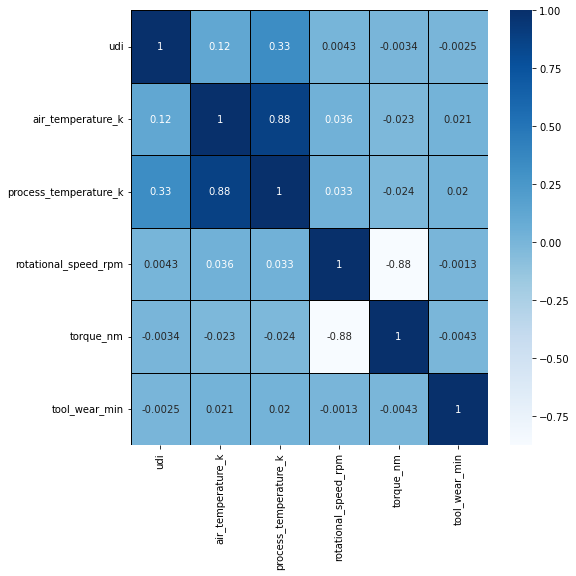

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, linewidths=0.5, linecolor='black', cmap='Blues')
plt.xticks(rotation=90)
plt.show()

Através do mapa de calor, podemos perceber uma pequena correlação dos dados entre air_temperature e process_temperature, mas não é algo que necessite de atenção.
Porém como temos duas informações idênticas, que parecem ser índices, vou remover estas colunas para ficarmos apenas com os dados de cada equipamento.

In [7]:
df.drop(['udi','product_id'],axis=1, inplace=True)

In [8]:
df.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,299.992515,309.992620,1537.419529,40.058512,108.098095
std,1.994710,1.488101,177.182908,9.950804,63.359915
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000


Como podemos ver no describe acima, as colunas foram removidas com sucesso.

# Analisando e tratando as colunas failure_type e type para categóricas

In [9]:
df.type.value_counts()

L    4022
M    1987
H     658
Name: type, dtype: int64

Na coluna Type constam dados dividos em 3 informações: L, M e H. Abaixo faço alguns procedimentos em relação a coluna das falhas para um melhor entendido destes dados.

In [10]:
df[df['type']=='L']['failure_type'].value_counts()

No Failure                  3861
Overstrain Failure            50
Heat Dissipation Failure      46
Power Failure                 39
Tool Wear Failure             19
Random Failures                7
Name: failure_type, dtype: int64

In [11]:
df[df['type']=='M']['failure_type'].value_counts()

No Failure                  1933
Heat Dissipation Failure      22
Power Failure                 20
Tool Wear Failure             10
Random Failures                1
Overstrain Failure             1
Name: failure_type, dtype: int64

In [12]:
df[df['type']=='H']['failure_type'].value_counts()

No Failure                  641
Heat Dissipation Failure      7
Power Failure                 4
Random Failures               4
Overstrain Failure            1
Tool Wear Failure             1
Name: failure_type, dtype: int64

Para converter os dados que estão como string para categóricos, utilizarei o LabelEncoder:

In [13]:
le = preprocessing.LabelEncoder()

df['type']=le.fit_transform(df['type'])
df

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,2,298.1,308.6,1551,42.8,0,No Failure
1,1,298.2,308.7,1408,46.3,3,No Failure
2,1,298.2,308.7,1408,40.0,9,No Failure
3,2,298.1,308.6,1425,41.9,11,No Failure
4,1,298.1,308.6,1558,42.4,14,No Failure
...,...,...,...,...,...,...,...
6662,1,298.8,308.3,1634,27.9,12,No Failure
6663,2,298.8,308.4,1604,29.5,14,No Failure
6664,0,298.9,308.4,1632,31.8,17,No Failure
6665,0,299.0,308.7,1408,48.5,25,No Failure


In [14]:
df.type.value_counts()

1    4022
2    1987
0     658
Name: type, dtype: int64

In [15]:
df['failure_type'].value_counts().sum()

6667

Feito o tratamento desta coluna e certificado q todos os dados constam no DF, sigo agora para o mesmo processo porém na coluna failure_type

In [16]:
# Categóricos
le = preprocessing.LabelEncoder()

df['failure_type']=le.fit_transform(df['failure_type'])
df

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,2,298.1,308.6,1551,42.8,0,1
1,1,298.2,308.7,1408,46.3,3,1
2,1,298.2,308.7,1408,40.0,9,1
3,2,298.1,308.6,1425,41.9,11,1
4,1,298.1,308.6,1558,42.4,14,1
...,...,...,...,...,...,...,...
6662,1,298.8,308.3,1634,27.9,12,1
6663,2,298.8,308.4,1604,29.5,14,1
6664,0,298.9,308.4,1632,31.8,17,1
6665,0,299.0,308.7,1408,48.5,25,1


In [17]:
df.failure_type.value_counts()

1    6435
0      75
3      63
2      52
5      30
4      12
Name: failure_type, dtype: int64

In [18]:
df.failure_type.value_counts().sum()

6667

Agora todos os dados do dataframe são númericos.

# Analisando e tratando as demais colunas

<AxesSubplot:>

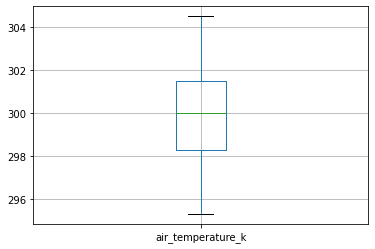

In [19]:
df.boxplot('air_temperature_k')

<AxesSubplot:>

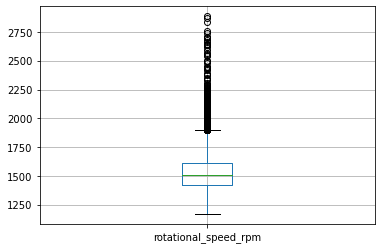

In [20]:
df.boxplot('rotational_speed_rpm')

<AxesSubplot:>

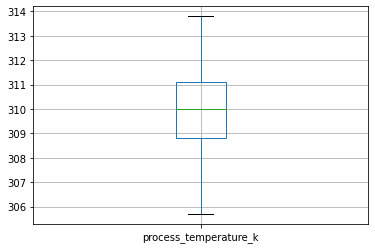

In [21]:
df.boxplot('process_temperature_k')

<AxesSubplot:>

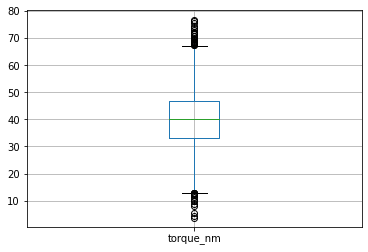

In [22]:
df.boxplot('torque_nm')

Através dos gráficos acima, podemos perceber uma grande quantidade de outliers nas colunas rotational_speed_rpm e torque_nm

Utilizarei o MinMax Scaler para escalonar os dados e depois tratar os outliers dessas duas colunas.

In [23]:
col = df.columns[:-1]
col

Index(['type', 'air_temperature_k', 'process_temperature_k',
       'rotational_speed_rpm', 'torque_nm', 'tool_wear_min'],
      dtype='object')

In [24]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[col])
df_scaled = pd.DataFrame(df_scaled, columns=col)
df_scaled['failure_type'] = df['failure_type']
df_scaled

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1.0,0.304348,0.358025,0.222934,0.535714,0.000000,1
1,0.5,0.315217,0.370370,0.139697,0.583791,0.011952,1
2,0.5,0.315217,0.370370,0.139697,0.497253,0.035857,1
3,1.0,0.304348,0.358025,0.149593,0.523352,0.043825,1
4,0.5,0.304348,0.358025,0.227008,0.530220,0.055777,1
...,...,...,...,...,...,...,...
6662,0.5,0.380435,0.320988,0.271246,0.331044,0.047809,1
6663,1.0,0.380435,0.333333,0.253783,0.353022,0.055777,1
6664,0.0,0.391304,0.333333,0.270081,0.384615,0.067729,1
6665,0.0,0.402174,0.370370,0.139697,0.614011,0.099602,1


<AxesSubplot:>

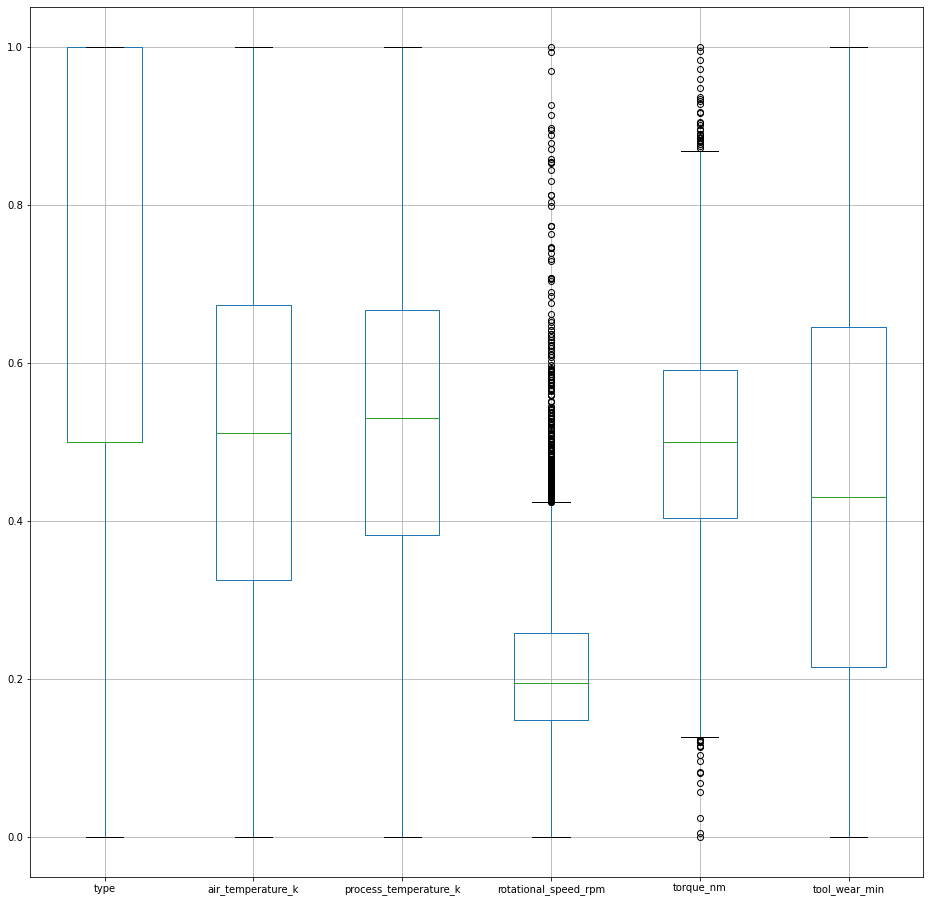

In [25]:
plt.figure(figsize=(16,16))
df_scaled[col].boxplot()

# Tratando dos outliers

In [26]:
#Coluna rotational_speed_rpm'
Q3 = np.quantile(df_scaled['rotational_speed_rpm'],0.75)
Q1 = np.quantile(df_scaled['rotational_speed_rpm'],0.25)
IQR = Q3-Q1
limite_sup = Q3+1.5*IQR
limite_inf = Q1-1.5*IQR
print('Limite superior é ',limite_sup,'\nLimite inferior é ',limite_inf)

Limite superior é  0.4238940628637953 
Limite inferior é  -0.01731664726426077


In [27]:
df_scaled[df_scaled['rotational_speed_rpm']>0.4234575087310828]

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
73,0.5,0.380435,0.382716,0.479045,0.232143,0.235060,1
108,0.0,0.336957,0.308642,0.476717,0.219780,0.788845,1
125,0.5,0.315217,0.308642,0.477299,0.241758,0.163347,1
183,0.5,0.282609,0.283951,0.457509,0.237637,0.167331,1
208,0.0,0.282609,0.345679,0.559371,0.204670,0.501992,1
...,...,...,...,...,...,...,...
6566,1.0,0.391304,0.506173,0.746217,0.138736,0.354582,1
6572,1.0,0.391304,0.506173,0.453434,0.245879,0.418327,1
6583,0.5,0.380435,0.481481,0.427823,0.254121,0.577689,1
6612,1.0,0.347826,0.358025,0.424331,0.225275,0.199203,1


In [28]:
mean_rpm = df_scaled[df_scaled['rotational_speed_rpm']<=0.4234575087310828]['rotational_speed_rpm'].mean()
df_scaled['rotational_speed_rpm']=np.where(df_scaled['rotational_speed_rpm']>0.4234575087310828,mean_rpm,df_scaled['rotational_speed_rpm'])
df_scaled.describe()


,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,0.599670,0.510056,0.529953,0.201385,0.498056,0.430670,1.038848
std,0.298767,0.216816,0.183716,0.074683,0.136687,0.252430,0.378887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.326087,0.382716,0.148137,0.403846,0.215139,1.000000
50%,0.500000,0.510870,0.530864,0.194994,0.500000,0.430279,1.000000
75%,1.000000,0.673913,0.666667,0.244761,0.590659,0.645418,1.000000
max,1.000000,1.000000,1.000000,0.423166,1.000000,1.000000,5.000000


In [29]:
#Coluna torque_nm
Q3 = np.quantile(df_scaled['torque_nm'],0.75)
Q1 = np.quantile(df_scaled['torque_nm'],0.25)
IQR = Q3-Q1
limite_sup = Q3+1.5*IQR
limite_inf = Q1-1.5*IQR
print('Limite superior é ',limite_sup,'\nLimite inferior é ',limite_inf)

Limite superior é  0.8708791208791206 
Limite inferior é  0.12362637362637391


In [30]:
mean_torque = df_scaled[df_scaled['torque_nm']<=0.8708791208791206]['torque_nm'].mean()

df_scaled['torque_nm']=np.where(df_scaled['torque_nm']>0.8708791208791206,mean_torque,df_scaled['torque_nm'])

df_scaled['torque_nm']=np.where(df_scaled['torque_nm']<0.12362637362637391,mean_torque,df_scaled['torque_nm'])

<AxesSubplot:>

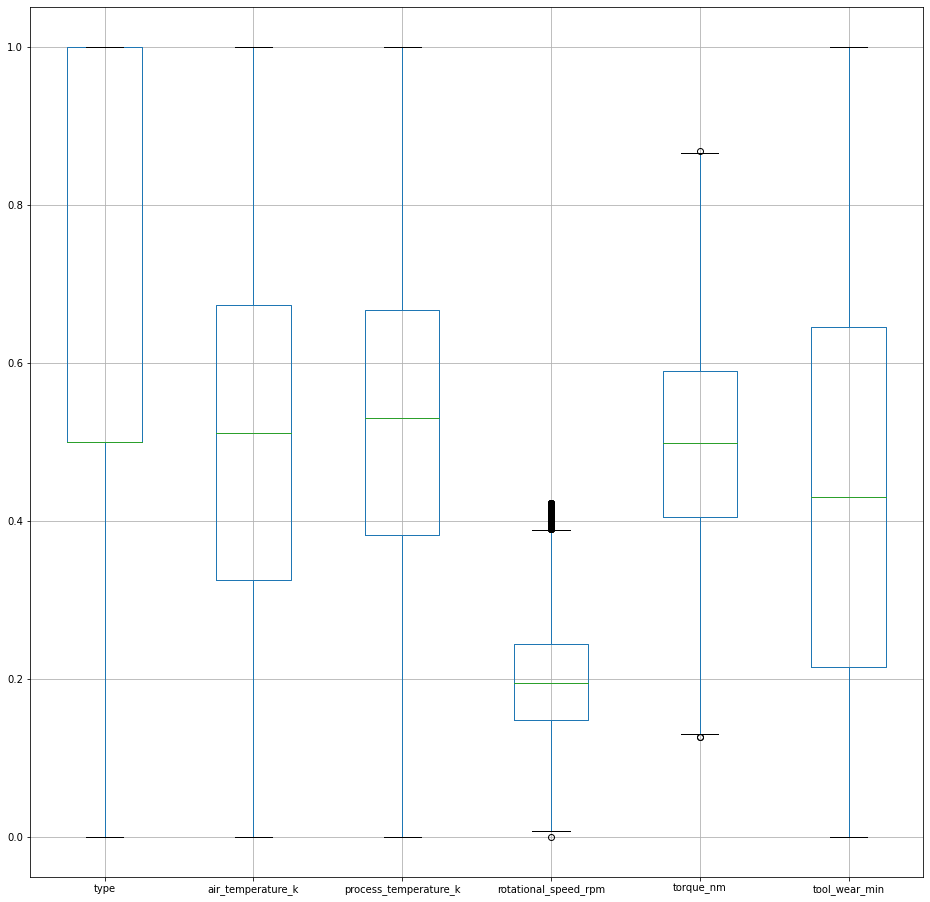

In [31]:
plt.figure(figsize=(16,16))
df_scaled[col].boxplot()

Visualização dos outliers após o tratamento utilizando variação interquartil e média.

# Criando a coluna target

In [32]:
df_scaled['target'] = df_scaled['failure_type']
df_scaled['target'] = df_scaled['target'].replace(1, 11)
df_scaled['target'] = df_scaled['target'].replace(0, 1)
df_scaled['target'] = df_scaled['target'].replace(2, 1)
df_scaled['target'] = df_scaled['target'].replace(3, 1)
df_scaled['target'] = df_scaled['target'].replace(4, 1)
df_scaled['target'] = df_scaled['target'].replace(5, 1)
df_scaled['target'] = df_scaled['target'].replace(11, 0)

Como haviam 6 tipos de dados na coluna Failure Type, após a categorização, os dados aperecem de 0 a 5, porém eu quero apenas saber quais apresentaram algum tipo de falha e outros não, não a falha especificamente, para isso criei uma nova coluna com os dados divididos em 0 (Não falha) e 1 (Falha)

# Dividindo o conjunto de dados em treinamento e testes e preparar as entradas e saídas

In [33]:
from sklearn.feature_selection import VarianceThreshold

In [34]:
var_thr = VarianceThreshold(threshold=0)
var_thr.fit_transform(df_scaled)
var_thr.get_support()
pd.Series(var_thr.get_support(),index=df_scaled.columns)

type                     True
air_temperature_k        True
process_temperature_k    True
rotational_speed_rpm     True
torque_nm                True
tool_wear_min            True
failure_type             True
target                   True
dtype: bool

In [35]:
X = df_scaled.drop(['target', 'failure_type'], axis=1)
y = df_scaled['target']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, shuffle=False)

Para este caso, separei 30% das informações totais para teste, e os restantes para treino.

# Modelo

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train,y_train)
y_pred_RF = RF_model.predict(X_test)

In [39]:
accuracy_rf = accuracy_score(y_test,y_pred_RF)
print('A acurácia do modelo Random Forest é: ',accuracy_rf*100)

A acurácia do modelo Random Forest é:  98.60069965017492


Alem deste modelo também testei outros, dentro eles o XGBClassifier que obteve a segunda melhor acurácia, 98,23%, pouco abaixo do modelo acima. Sendo assim, mantive apenas o melhor modelo para este desafio. 

# Serialização de objetos

In [40]:
import pickle
with open ('RF_model.pickle','wb') as model:
    pickle.dump(RF_model,model)
    model.close()

Utilizei o pickle para gerar o arquivo com o modelo final. Este arquivo será utilizado no arquivo de teste.